In [30]:
import ast
import json
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

In [2]:
df = pd.read_csv("features.csv")
df.head()

,clip,split,engagement_class,features
0,DAiSEE\DataSet\Train\110001\1100011002\1100011...,Train,2,"[[2.536451600790529, 0.3208898518646281, 18.88..."
1,DAiSEE\DataSet\Train\110001\1100011003\1100011...,Train,2,"[[2.9946811775481077, 0.38348249442368526, 18...."
2,DAiSEE\DataSet\Train\110001\1100011004\1100011...,Train,3,"[[3.018555394812198, 0.3579455265819088, 18.85..."
3,DAiSEE\DataSet\Train\110001\1100011005\1100011...,Train,3,"[[2.661259769475439, 0.40877269439290326, 18.4..."
4,DAiSEE\DataSet\Train\110001\1100011006\1100011...,Train,3,"[[2.978869316858684, 0.3905124837953327, 18.18..."


In [3]:
df.shape

(8924, 4)

In [4]:
def safe_parse(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return []

In [5]:
def relabel_class(cls):
    if cls in [0, 1]:
        return 0
    elif cls == 2:
        return 1
    elif cls == 3:
        return 2
    else:
        return -1

In [14]:
df["features"] = df["features"].apply(safe_parse)
df = df[df['features'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
df.shape

(8920, 5)

In [15]:
original_counter = Counter(df['engagement_class'])
original_counter

Counter({2: 4421, 3: 3983, 1: 455, 0: 61})

In [16]:
df['relabelled_enagegement_class'] = df['engagement_class'].apply(relabel_class)
df.head()

,clip,split,engagement_class,features,relabelled_enagegement_class
0,DAiSEE\DataSet\Train\110001\1100011002\1100011...,Train,2,"[[2.536451600790529, 0.3208898518646281, 18.88...",1
1,DAiSEE\DataSet\Train\110001\1100011003\1100011...,Train,2,"[[2.9946811775481077, 0.38348249442368526, 18....",1
2,DAiSEE\DataSet\Train\110001\1100011004\1100011...,Train,3,"[[3.018555394812198, 0.3579455265819088, 18.85...",2
3,DAiSEE\DataSet\Train\110001\1100011005\1100011...,Train,3,"[[2.661259769475439, 0.40877269439290326, 18.4...",2
4,DAiSEE\DataSet\Train\110001\1100011006\1100011...,Train,3,"[[2.978869316858684, 0.3905124837953327, 18.18...",2


In [17]:
counter_after_relabel = Counter(df['relabelled_enagegement_class'])
counter_after_relabel

Counter({1: 4421, 2: 3983, 0: 516})

In [18]:
def normalize_frames(features_list, target_frames=300, pad_threshold=5):
    """
    Helper function to normalize frame count to target_frames (300):
    - If frames >= 300: take first 300 frames
    - If frames < 300 and difference <= pad_threshold: pad by repeating last frame
    - Otherwise: return None (skip this sample)
    """
    features = np.array(features_list)
    current_frames = features.shape[0]
    
    if current_frames >= target_frames:
        # Take first 300 frames
        return features[:target_frames]
    
    elif current_frames < target_frames and (target_frames - current_frames) <= pad_threshold:
        # Pad by repeating the last frame
        frames_to_pad = target_frames - current_frames
        last_frame = features[-1:]  # Shape: (1, 6)
        padding = np.repeat(last_frame, frames_to_pad, axis=0)  # Shape: (frames_to_pad, 6)
        return np.vstack([features, padding])  # Shape: (300, 6)
    
    else:
        # Too many frames missing, skip this sample
        return None


In [19]:
def oversample_engagement_data(df):
    """
    Apply the oversampling method based on the diagram:
    1. Extract 60 average frames from 300 frames (window size = 5)
    2. Divide into 10 sequences of 6 frames each
    3. For each sequence, create 6 segments (1 frame each)
    4. Sample based on engagement class:
       - High/Very High (class 1,2): 1 sample using 1st segment from each sequence
       - Low (class 0): 6 samples using all segment combinations
    """
    oversampled_data = []
    skipped_count = 0
    normalized_count = 0
    
    for index, row in df.iterrows():
        raw_features = row['features']
        engagement_class = row['relabelled_enagegement_class']
        
        # Normalize frame count to 300
        features = normalize_frames(raw_features)
        
        if features is None:
            print(f"Skipping row {index}: too many frames missing (original: {len(raw_features)} frames)")
            skipped_count += 1
            continue
        
        # Check if normalization was applied
        if len(raw_features) != 300:
            normalized_count += 1
            
        # Ensure features have the expected shape
        if features.shape[1] != 6:
            print(f"Skipping row {index}: unexpected feature dimension {features.shape[1]} (expected 6)")
            skipped_count += 1
            continue
        
        # Step 1: Extract 60 average frames (window size = 5)
        averaged_frames = []
        for i in range(0, 300, 5):  # 0, 5, 10, ..., 295
            window = features[i:i+5]  # 5 consecutive frames
            avg_frame = np.mean(window, axis=0)  # Average across 5 frames
            averaged_frames.append(avg_frame)
        
        averaged_frames = np.array(averaged_frames)  # Shape: (60, 6)
        
        # Step 2: Divide into 10 sequences of 6 frames each
        sequences = []
        for seq_idx in range(10):
            start_idx = seq_idx * 6
            end_idx = start_idx + 6
            sequence = averaged_frames[start_idx:end_idx]  # Shape: (6, 6)
            sequences.append(sequence)
        
        # Step 3 & 4: Sample based on engagement class
        if engagement_class in [1, 2]:  # High (1) and Very High (2)
            # Get 1 sample: 1st segment from each sequence
            sample = []
            for seq in sequences:
                sample.append(seq[0])  # 1st segment (1st frame) from each sequence
            
            sample_data = np.array(sample)  # Shape: (10, 6)
            oversampled_data.append({
                'features': sample_data,
                'engagement_class': engagement_class,
                'original_index': index,
                'clip': row['clip'],
                'split': row['split']
            })
            
        elif engagement_class == 0:  # Low (combined very_low and low)
            # Get 6 samples: each using different segment from each sequence
            for segment_idx in range(6):
                sample = []
                for seq in sequences:
                    sample.append(seq[segment_idx])  # segment_idx-th frame from each sequence
                
                sample_data = np.array(sample)  # Shape: (10, 6)
                oversampled_data.append({
                    'features': sample_data,
                    'engagement_class': engagement_class,
                    'original_index': index,
                    'clip': row['clip'],
                    'split': row['split'],
                    'segment_idx': segment_idx  # Track which segment combination this is
                })
    
    print(f"Processing complete:")
    print(f"- Normalized {normalized_count} videos (padded or truncated)")
    print(f"- Skipped {skipped_count} videos (too many missing frames or wrong dimensions)")
    print(f"- Successfully processed {len(oversampled_data)} samples")
    
    return oversampled_data

In [20]:
print("Applying oversampling method...")
oversampled_data = oversample_engagement_data(df)
print(f"Total oversampled samples: {len(oversampled_data)}")

Applying oversampling method...
Skipping row 1285: too many frames missing (original: 247 frames)
Skipping row 3110: too many frames missing (original: 285 frames)
Skipping row 3343: too many frames missing (original: 123 frames)
Skipping row 3358: too many frames missing (original: 255 frames)
Skipping row 3367: too many frames missing (original: 92 frames)
Skipping row 3528: too many frames missing (original: 294 frames)
Skipping row 3530: too many frames missing (original: 278 frames)
Skipping row 3905: too many frames missing (original: 279 frames)
Skipping row 4301: too many frames missing (original: 235 frames)
Skipping row 4362: too many frames missing (original: 171 frames)
Skipping row 4521: too many frames missing (original: 282 frames)
Skipping row 5276: too many frames missing (original: 270 frames)
Skipping row 5282: too many frames missing (original: 283 frames)
Skipping row 5416: too many frames missing (original: 289 frames)
Skipping row 5417: too many frames missing (o

In [21]:
counter_after_oversampling = Counter([item['engagement_class'] for item in oversampled_data])
counter_after_oversampling

Counter({1: 4393, 2: 3940, 0: 3030})

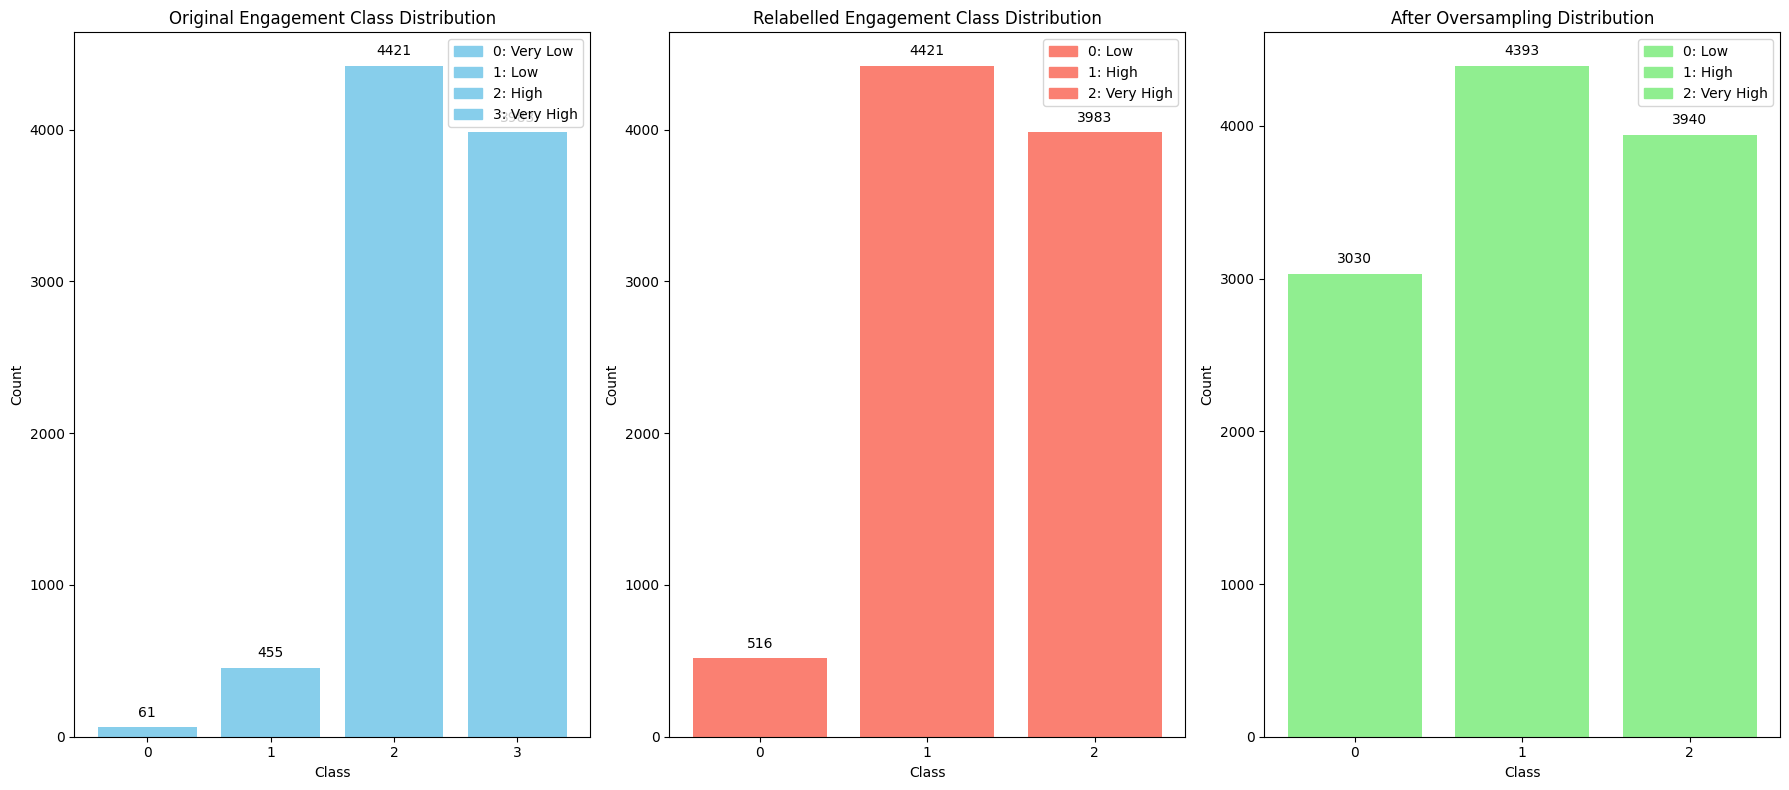

In [29]:
original_labels = list(original_counter.keys())
original_values = list(original_counter.values())

relabelled_labels = list(counter_after_relabel.keys())
relabelled_values = list(counter_after_relabel.values())

oversampled_labels = list(counter_after_oversampling.keys())
oversampled_values = list(counter_after_oversampling.values())

# Define legends for each subplot
legend_original = [
    Patch(color='skyblue', label='0: Very Low'),
    Patch(color='skyblue', label='1: Low'),
    Patch(color='skyblue', label='2: High'),
    Patch(color='skyblue', label='3: Very High')
]

legend_relabelled = [
    Patch(color='salmon', label='0: Low'),
    Patch(color='salmon', label='1: High'),
    Patch(color='salmon', label='2: Very High')
]

legend_oversampled = [
    Patch(color='lightgreen', label='0: Low'),
    Patch(color='lightgreen', label='1: High'),
    Patch(color='lightgreen', label='2: Very High')
]

fig, axs = plt.subplots(1, 3, figsize=(18, 8))

# --- Original distribution ---
axs[0].bar(original_labels, original_values, color='skyblue')
axs[0].set_title('Original Engagement Class Distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[0].set_xticks(original_labels)
for i, v in enumerate(original_values):
    axs[0].text(original_labels[i], v + 50, str(v), ha='center', va='bottom')
axs[0].legend(handles=legend_original, loc='upper right')

# --- After relabeling ---
axs[1].bar(relabelled_labels, relabelled_values, color='salmon')
axs[1].set_title('Relabelled Engagement Class Distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')
axs[1].set_xticks(relabelled_labels)
for i, v in enumerate(relabelled_values):
    axs[1].text(relabelled_labels[i], v + 50, str(v), ha='center', va='bottom')
axs[1].legend(handles=legend_relabelled, loc='upper right')

# --- After oversampling ---
axs[2].bar(oversampled_labels, oversampled_values, color='lightgreen')
axs[2].set_title('After Oversampling Distribution')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Count')
axs[2].set_xticks(oversampled_labels)
for i, v in enumerate(oversampled_values):
    axs[2].text(oversampled_labels[i], v + 50, str(v), ha='center', va='bottom')
axs[2].legend(handles=legend_oversampled, loc='upper right')

plt.tight_layout()
plt.show()

In [31]:
oversampled_df = pd.DataFrame(oversampled_data)
oversampled_df['features'] = oversampled_df['features'].apply(lambda x: json.dumps(x.tolist()))
oversampled_df.to_csv("oversampled_data.csv", index=False)